In [2]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
import inspect

top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from longestpath.gen import gen_num_edges
from benchmarking import RandomParams, Benchmark, new_random_benchmark, Solver, new_graph_file_benchmark, new_benchmark
import re

In [124]:
def generate():
  return [
    gen_num_edges(25, round(25 * degree))
      for degree in np.arange(1, 2.1, 0.1) for _ in range(10)
  ]

params_code = inspect.getsource(generate)
graphs = generate()

benchmark = new_benchmark(graphs, solvers=[
	Solver("brute", "FAST_BOUND"),
	Solver("brute", "BRUTE_FORCE"),
  Solver("ilp"),
	# Solver("kalp", threads=4),
], params_code = params_code, override_benchmark_path="../benchmarks/test")

benchmark.benchmark_path


'../benchmarks/test(17)'

In [45]:
benchmark = Benchmark.load("../benchmarks/brute_ilp_kalp_10_runs_deg1-2")

In [125]:
benchmark.run(retryFailures=True, timeout=2)


graph: 0.txt, solver: brute('FAST_BOUND') ... 

✅
length: 4, run_time: 7e-06
graph: 1.txt, solver: brute('FAST_BOUND') ... ✅
length: 6, run_time: 7e-06
graph: 2.txt, solver: brute('FAST_BOUND') ... ✅
length: 7, run_time: 8e-06
graph: 3.txt, solver: brute('FAST_BOUND') ... ✅
length: 4, run_time: 6e-06
graph: 4.txt, solver: brute('FAST_BOUND') ... ✅
length: 5, run_time: 7e-06
graph: 5.txt, solver: brute('FAST_BOUND') ... ✅
length: 6, run_time: 7e-06
graph: 6.txt, solver: brute('FAST_BOUND') ... ✅
length: 9, run_time: 6e-06
graph: 7.txt, solver: brute('FAST_BOUND') ... ✅
length: 6, run_time: 6e-06
graph: 8.txt, solver: brute('FAST_BOUND') ... ✅
length: 9, run_time: 7e-06
graph: 9.txt, solver: brute('FAST_BOUND') ... ✅
length: 6, run_time: 7e-06
graph: 10.txt, solver: brute('FAST_BOUND') ... ✅
length: 12, run_time: 9e-06
graph: 11.txt, solver: brute('FAST_BOUND') ... ✅
length: 6, run_time: 9e-06
graph: 12.txt, solver: brute('FAST_BOUND') ... ✅
length: 7, run_time: 8e-06
graph: 13.txt, solver: brute('FAST_BOUND') ... ✅
length: 6, run_tim

In [126]:
df_ = benchmark.get_dataframe()
df = df_
df

,path,run_time,length,solver,graph_id,status,objective_value,failure,solver_name,vertices,edges,average_out_degree
0,"[1, 8, 14, 24, 23]",0.000007,4.0,0,0,NaN,NaN,NaN,brute('FAST_BOUND'),25,25,1.0
1,"[8, 7, 20, 5, 21, 0, 4]",0.000007,6.0,0,1,NaN,NaN,NaN,brute('FAST_BOUND'),25,25,1.0
2,"[14, 6, 5, 2, 10, 23, 7, 11]",0.000008,7.0,0,2,NaN,NaN,NaN,brute('FAST_BOUND'),25,25,1.0
3,"[17, 22, 15, 16, 6]",0.000006,4.0,0,3,NaN,NaN,NaN,brute('FAST_BOUND'),25,25,1.0
4,"[20, 13, 12, 21, 6, 10]",0.000007,5.0,0,4,NaN,NaN,NaN,brute('FAST_BOUND'),25,25,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
325,"[2, 15, 11, 18, 16, 20, 6, 0, 5, 4, 14, 12, 9,...",0.674986,16.0,2,105,OPTIMAL,17.0,NaN,ilp(),25,50,2.0
326,"[4, 20, 13, 14, 0, 11, 5, 2, 21, 23, 22, 8, 17...",0.543007,15.0,2,106,OPTIMAL,16.0,NaN,ilp(),25,50,2.0
327,"[17, 13, 11, 1, 5, 0, 2, 3, 6, 24, 12, 4, 7, 21]",0.478403,13.0,2,107,OPTIMAL,14.0,NaN,ilp(),25,50,2.0
328,"[12, 20, 7, 2, 16, 21, 15, 22, 3, 10, 4, 24, 8...",0.741144,17.0,2,108,OPTIMAL,18.0,NaN,ilp(),25,50,2.0


run_time    Axes(0.125,0.11;0.775x0.77)
dtype: object

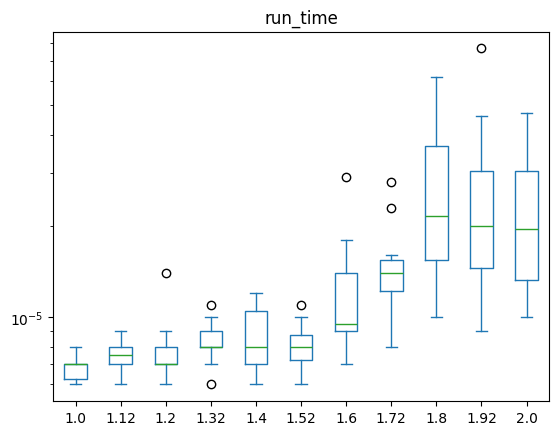

In [127]:
df[df["solver"] == 0][["run_time", "average_out_degree"]].plot.box(by="average_out_degree", logy=True)


In [128]:
df_grouped = df.groupby(['average_out_degree', 'solver', 'solver_name']).agg({"run_time": "mean", "failure": "any"}).reset_index()
df_grouped_failures_removed = df_grouped[df_grouped["failure"] == False]
to_plot = df_grouped_failures_removed.pivot(index='average_out_degree', columns='solver_name', values='run_time').rename(columns=lambda x: x + " (average)")

In [129]:
df_grouped_failures_removed.groupby(["solver_name"]).agg({"failure": "count"}).reset_index().rename(columns={"failure": "count"})

,solver_name,count
0,brute('BRUTE_FORCE'),11
1,brute('FAST_BOUND'),11
2,ilp(),8


In [130]:
df_grouped_failures_removed.head()

,average_out_degree,solver,solver_name,run_time,failure
0,1.00,0,brute('FAST_BOUND'),0.000007,False
1,1.00,1,brute('BRUTE_FORCE'),0.000005,False
2,1.00,2,ilp(),0.433484,False
3,1.12,0,brute('FAST_BOUND'),0.000008,False
4,1.12,1,brute('BRUTE_FORCE'),0.000006,False


In [131]:
to_plot


solver_name,brute('BRUTE_FORCE') (average),brute('FAST_BOUND') (average),ilp() (average)
average_out_degree,,,
1.00,0.000005,0.000007,0.433484
1.12,0.000006,0.000008,0.439466
1.20,0.000007,0.000008,0.506868
1.32,0.000008,0.000008,NaN
1.40,0.000008,0.000009,0.575009
1.52,0.000007,0.000008,0.445953
1.60,0.000013,0.000012,0.595625
1.72,0.000021,0.000015,0.772418
1.80,0.000030,0.000027,0.811299


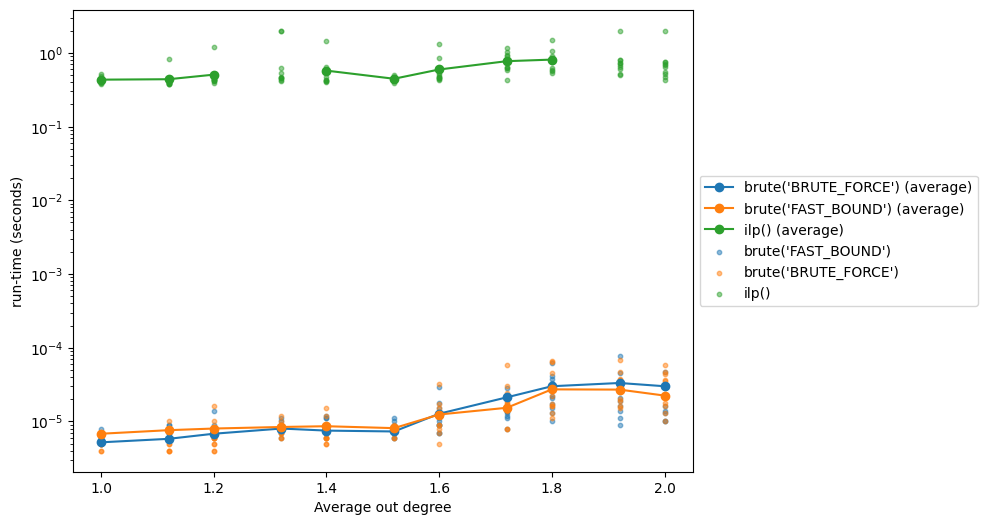

In [133]:
view = df[['average_out_degree', 'solver_name','length', 'run_time']]

# to_plot = df.groupby(['average_out_degree', 'solver', 'solver_name']).agg({'run_time': 'mean'}).reset_index() \
#     .pivot(index='average_out_degree', columns='solver_name', values='run_time') \
#     .rename(columns=lambda x: x + " (average)");

to_plot.plot(style="o-")

for solver_name in benchmark.solver_names():
    solver_df = df[df["solver_name"] == solver_name]  # Select rows where run-time is not null
    plt.scatter(solver_df['average_out_degree'], solver_df['run_time'], label=solver_name, alpha=0.5, s=10)

# plt.yscale('log')
# plt.xticks(np.arange(1, 4.0, 0.5))
plt.ylabel("run-time (seconds)")
plt.xlabel("Average out degree")
# plt.title("Longest path solve-time for random directed graphs with 50 vertices")
# plt.axhline(y=0.015, color='black', linestyle='--', label='run-time cutoff', linewidth=1, alpha=0.5, zorder=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# df[df["solver"] == 0].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
# df[df["solver"] == 1].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
# plt.ylim(0, to_plot.max().max())

plt.gcf().set_size_inches(8, 6)
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')

In [10]:
to_plot2 = df.groupby("solver").get_group(0)[["run_time", "average_out_degree"]].sort_values(by="average_out_degree")
to_plot2


,run_time,average_out_degree
0,0.000016,1.0
27,0.000019,1.0
28,0.000010,1.0
29,0.000009,1.0
30,0.000009,1.0
...,...,...
519,0.000682,2.0
520,0.000099,2.0
521,0.000282,2.0
510,0.000178,2.0


<Axes: xlabel='average_out_degree'>

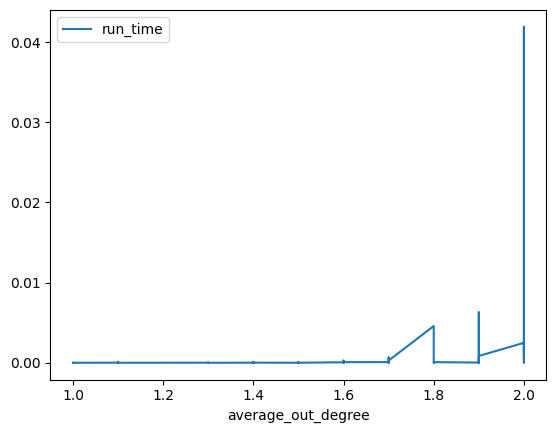

In [11]:
to_plot2.plot(x="average_out_degree", y="run_time")

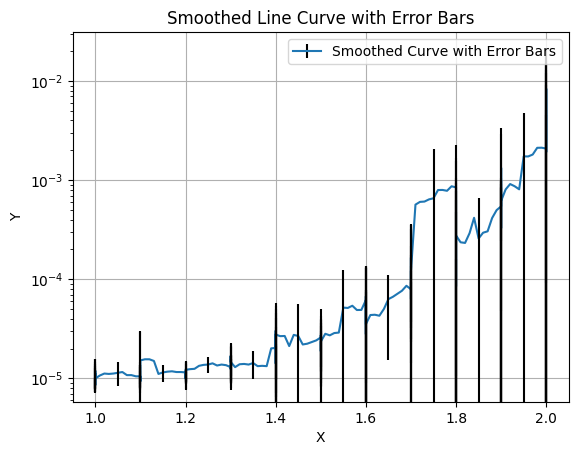

In [12]:
rolling_window = 10
df_smoothed = to_plot2.rolling(rolling_window, center=True).mean()
df_std = to_plot2.rolling(rolling_window, center=True).std()

# Plot the smoothed curve with error bars
plt.errorbar(df_smoothed['average_out_degree'], df_smoothed['run_time'], yerr=df_std['run_time'], label='Smoothed Curve with Error Bars', errorevery=5, barsabove=True, ecolor="black")
plt.xlabel('X')
plt.ylabel('Y')
plt.yscale("log")
plt.title('Smoothed Line Curve with Error Bars')
plt.legend()
plt.grid(True)
plt.show()